<h1>News Classification with Transformers on the Ilur Dataset</h1>

<h2>Objective</h2>
<p>Build a multi-class classification model to predict the category of a news article from the Ilur dataset. The dataset consists of 7 distinct classes:</p>
<ul>
  <li><strong>economy</strong></li>
  <li><strong>accidents</strong></li>
  <li><strong>sport</strong></li>
  <li><strong>society</strong></li>
  <li><strong>politics</strong></li>
  <li><strong>weather</strong></li>
  <li><strong>culture</strong></li>
</ul>

<p><strong>Problem Statement:</strong> Given a news article as input, the model must classify it into one of the 7 categories listed above.</p>
<p><strong>Implementation:</strong> This classification task is implemented using <code>transformers</code> to generate text embeddings and train a classification model on top of these embeddings.</p>


<h2>Importing Required Packages</h2>

<p>Before starting, ensure you have all the necessary packages installed. If a package is missing, you can install it using <code>pip</code>. Below is the list of required imports for this project:</p>


In [3]:
from transformers import AutoModel, AutoTokenizer

import torch 
import torch.nn.functional as F
from torch import Tensor

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from datasets import load_dataset

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<h2>Load Dataset and Move Model to GPU (if available)</h2>


In [4]:
model = AutoModel.from_pretrained('Metric-AI/armenian-text-embeddings-1')
tokenizer = AutoTokenizer.from_pretrained('Metric-AI/armenian-text-embeddings-1')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
dataset = load_dataset('Metric-AI/ILUR-news-text-classification-corpus-formatted')

In [5]:
print(dataset)
print(dataset['train'].unique('class'))

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'class', 'source'],
        num_rows: 9821
    })
    test: Dataset({
        features: ['Sentence', 'class', 'source'],
        num_rows: 2445
    })
})
['economy', 'accidents', 'sport', 'society', 'politics', 'weather', 'culture']


<h2>Our Model is Not Symmetric</h2>

<p>You can add to the text <code>'query: '</code> or <code>'passage: '</code> or keep it as it is for experimentation, because it is not clear in classification tasks what prompt is generally preferable.</p>

In [6]:
def add_query_prefix(example):
    example['Sentence'] = 'query: ' + example['Sentence']
    return example

dataset = dataset.map(add_query_prefix)

<h2>Transformer for Embedding Generation with Manual Pooling</h2>

<p>In this approach, we manually write a pooling function called <code>average_pool</code> and an <code>embed function</code> that uses <code>eval()</code> and <code>torch.no_grad()</code> to turn the transformer model into inference mode. This allows us to generate embeddings for both training and testing sentences. The <code>average_pool</code> function computes the average of token embeddings, while the <code>embed</code> function processes sentences and generates the embeddings by passing them through the transformer model.</p>

<p>For more information and advanced usage, visit the official <a href="https://huggingface.co/transformers/" target="_blank">Transformers page</a>.</p>


In [7]:
def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
    
def embed_function(batch):    
    model.eval()
    inputs = tokenizer(batch['Sentence'], max_length = 512, padding=True, truncation=True, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    embeddings = average_pool(outputs.last_hidden_state, inputs['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    embeddings = embeddings.cpu().numpy()
    batch['embedding'] = embeddings.tolist()
    
    del inputs
    del outputs
    torch.cuda.empty_cache()
    return batch

dataset = dataset.map(embed_function, batched=True, batch_size=32)

Map:   0%|          | 0/2445 [00:00<?, ? examples/s]

<p>Here’s an example of how the dataset looks after adding the embeddings:</p>


In [8]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'class', 'source', 'embedding'],
        num_rows: 9821
    })
    test: Dataset({
        features: ['Sentence', 'class', 'source', 'embedding'],
        num_rows: 2445
    })
})


<h2>Using Embeddings for Model Training</h2>

<p>Now, we need to extract the embeddings from the dataset. These embeddings are stored in the <code>embedding</code> column and will be returned as a list. We then convert this list into a <code>numpy</code> array, which allows us to fit a model. Since the dataset contains labels, we can train a supervised model, but you can also opt for unsupervised models if desired.</p>

<p>After converting the embeddings to a <code>numpy</code> array, the model can be trained using these embeddings as features along with the labels from the dataset.</p>


In [9]:
X_train = np.vstack(dataset['train']['embedding'])
y_train = dataset['train']['class']
X_test = np.vstack(dataset['test']['embedding'])
y_test = dataset['test']['class']

lda = LinearDiscriminantAnalysis()
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

lda.fit(X_train, y_train_encoded)

LinearDiscriminantAnalysis()

<h2>Model Evaluation on Train and Test Sets</h2>

<p>Evaluate the model on both the train and test sets. As observed, the model shows high performance on both, indicating that it fits well on the train set and generalizes effectively on the test set. Additionally, large language models (LLMs) are generally less prone to overfitting.</p>


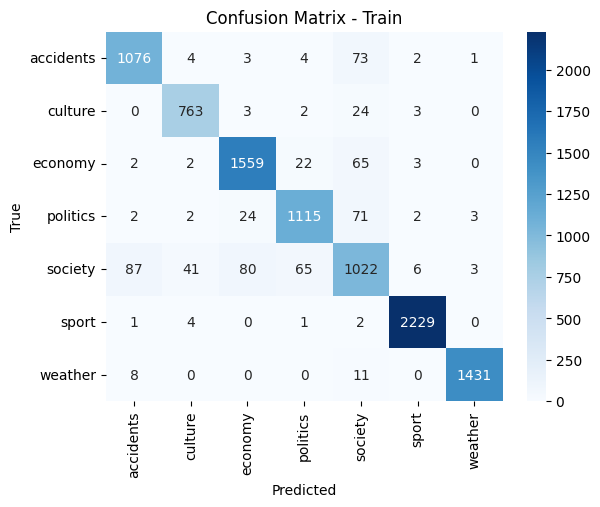

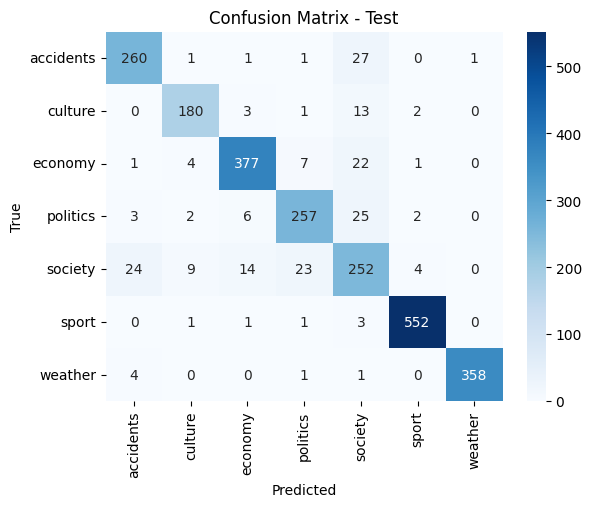

In [10]:
labels = label_encoder.classes_

y_pred_train = lda.predict(X_train)
cm_train = confusion_matrix(y_train_encoded, y_pred_train)

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

y_pred_test = lda.predict(X_test)
cm_test = confusion_matrix(y_test_encoded, y_pred_test)

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [11]:
print('Train results')
f1 = f1_score(y_train_encoded, y_pred_train, average='weighted')
print(f'F1 Score (Weighted): {f1:.2f}')

print('Test results')
f1 = f1_score(y_test_encoded, y_pred_test, average='weighted')
print(f'F1 Score (Weighted): {f1:.2f}')

Train results
F1 Score (Weighted): 0.94
Test results
F1 Score (Weighted): 0.92
